In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import aptwrapper
import numpy as np
import pandas as pd

In [2]:
images = pickle.load(open("./cache/maps_aligned_processed.pkl", "rb"))
# images = {k: v for k, v in images.items() if v.experiment.item() == 'recovery_timeline'}
ibtable = pickle.load(open("./cache/ibtable.pkl", "rb"))

# IB anatomy

In [3]:
from matplotlib.patches import bbox_artist
from skimage.morphology import binary_erosion, disk, square
from scipy.ndimage import center_of_mass
from skimage.morphology import binary_dilation

def d2edge(mask: np.ndarray):
    dilution_factor = 2
    mask = binary_dilation(mask, square(2*dilution_factor + 1))
    original_mask = np.copy(mask)
    distances = np.zeros_like(mask, dtype=int)
    i = -dilution_factor

    while mask.any():
        distances[mask] = i
        i += 1
        mask = binary_erosion(mask, square(3))

    return np.where(original_mask, distances, np.nan)

# Make a dataframe of every pixel with its distance to edge, beta ratio, and PLL
df_ibanatomy = pd.concat(
    [pd.DataFrame(dict(
        d2e = d2edge(im.ib_labels.data).flatten(),
        pll = im.pll.data.flatten(),
        beta_ratio = (im.amp1625/im.amp1650).data.flatten(),
        is_epoxy = ~im.cell_labels.data.flatten().astype(bool),
        cell_label = im.cell_labels.data.flatten(),
        ib_label = im.ib_labels.data.flatten(),
        series = im.series.item(),
        condition = im.condition.item(),
        replicate = im.replicate.item(),
    )) for im in images.values()]
)

df_ibanatomy = df_ibanatomy.assign(
    ib_id   = df_ibanatomy.series + '-' + df_ibanatomy.condition + '-' + df_ibanatomy.replicate + '-' + df_ibanatomy.ib_label.astype(str),
    cell_id = df_ibanatomy.series + '-' + df_ibanatomy.condition + '-' + df_ibanatomy.replicate + '-' + df_ibanatomy.cell_label.astype(str),
)

# Normalise beta ratio to mean of each cell
df_ibanatomy = df_ibanatomy.groupby(['series', 'condition', 'replicate', 'cell_label'], group_keys=False).apply(lambda x: x.assign(beta_ratio=x.beta_ratio/x.beta_ratio.mean()))
df_ibanatomy = df_ibanatomy.dropna(subset='d2e').reset_index()
df_ibanatomy = df_ibanatomy.query('not is_epoxy')

# df

/var/folders/m4/tld763w57mz1njb87w177rlrhl_dmw/T/ipykernel_87549/673363003.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ibanatomy = df_ibanatomy.groupby(['series', 'condition', 'replicate', 'cell_label'], group_keys=False).apply(lambda x: x.assign(beta_ratio=x.beta_ratio/x.beta_ratio.mean()))


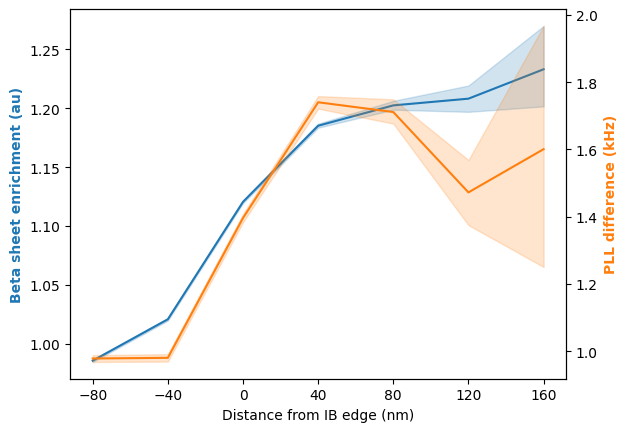

In [4]:
def plot_ib_anatomy(ax=None):
    if ax is None: fig, ax = plt.subplots()
    tax = ax.twinx()

    ddf = df_ibanatomy.groupby('ib_id').filter(lambda x: x.d2e.max() >= 1)#.query('series != "november"')

    sns.lineplot(x=ddf.d2e*40, y=ddf.beta_ratio, ax=ax)
    sns.lineplot(x=ddf.d2e*40, y=ddf.pll, c='C1', ax=tax)

    ax.set_xlabel('Distance from IB edge (nm)')
    ax.set_ylabel('Beta sheet enrichment (au)', c='C0', weight='bold')
    tax.set_ylabel('PLL difference (kHz)', c='C1', weight='bold')

    # Put 1 (beta ratio) and 0 (pll) on the same height and show that reference line
    y1, y2 = ax.get_ylim()
    y3, y4 = tax.get_ylim()
    # tax.set_ylim((y1-1)*y4/(y2-1), y4)
    # ax.axhline(1, ls='--', lw=.5, c='k', alpha=.5)
    ax.xaxis.set_major_locator(plt.MultipleLocator(40))

plot_ib_anatomy()

### Analysis of edge region

53.37398373983739


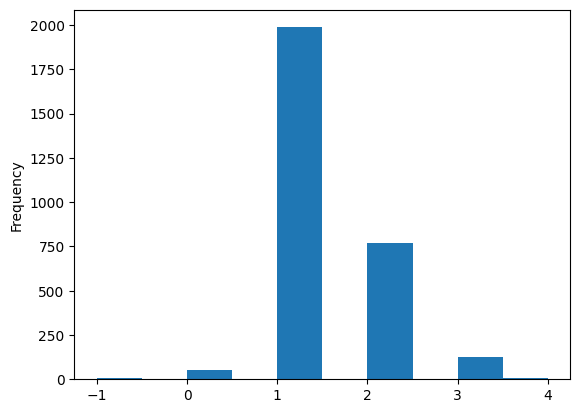

In [5]:
df_ibanatomy.groupby('ib_id').d2e.max().plot.hist()
mean_ib_radius = df_ibanatomy.groupby('ib_id').d2e.max().mean() * 40
print(mean_ib_radius)

# Correlation heatmap

alpha_threshold = 0.9999471179270227


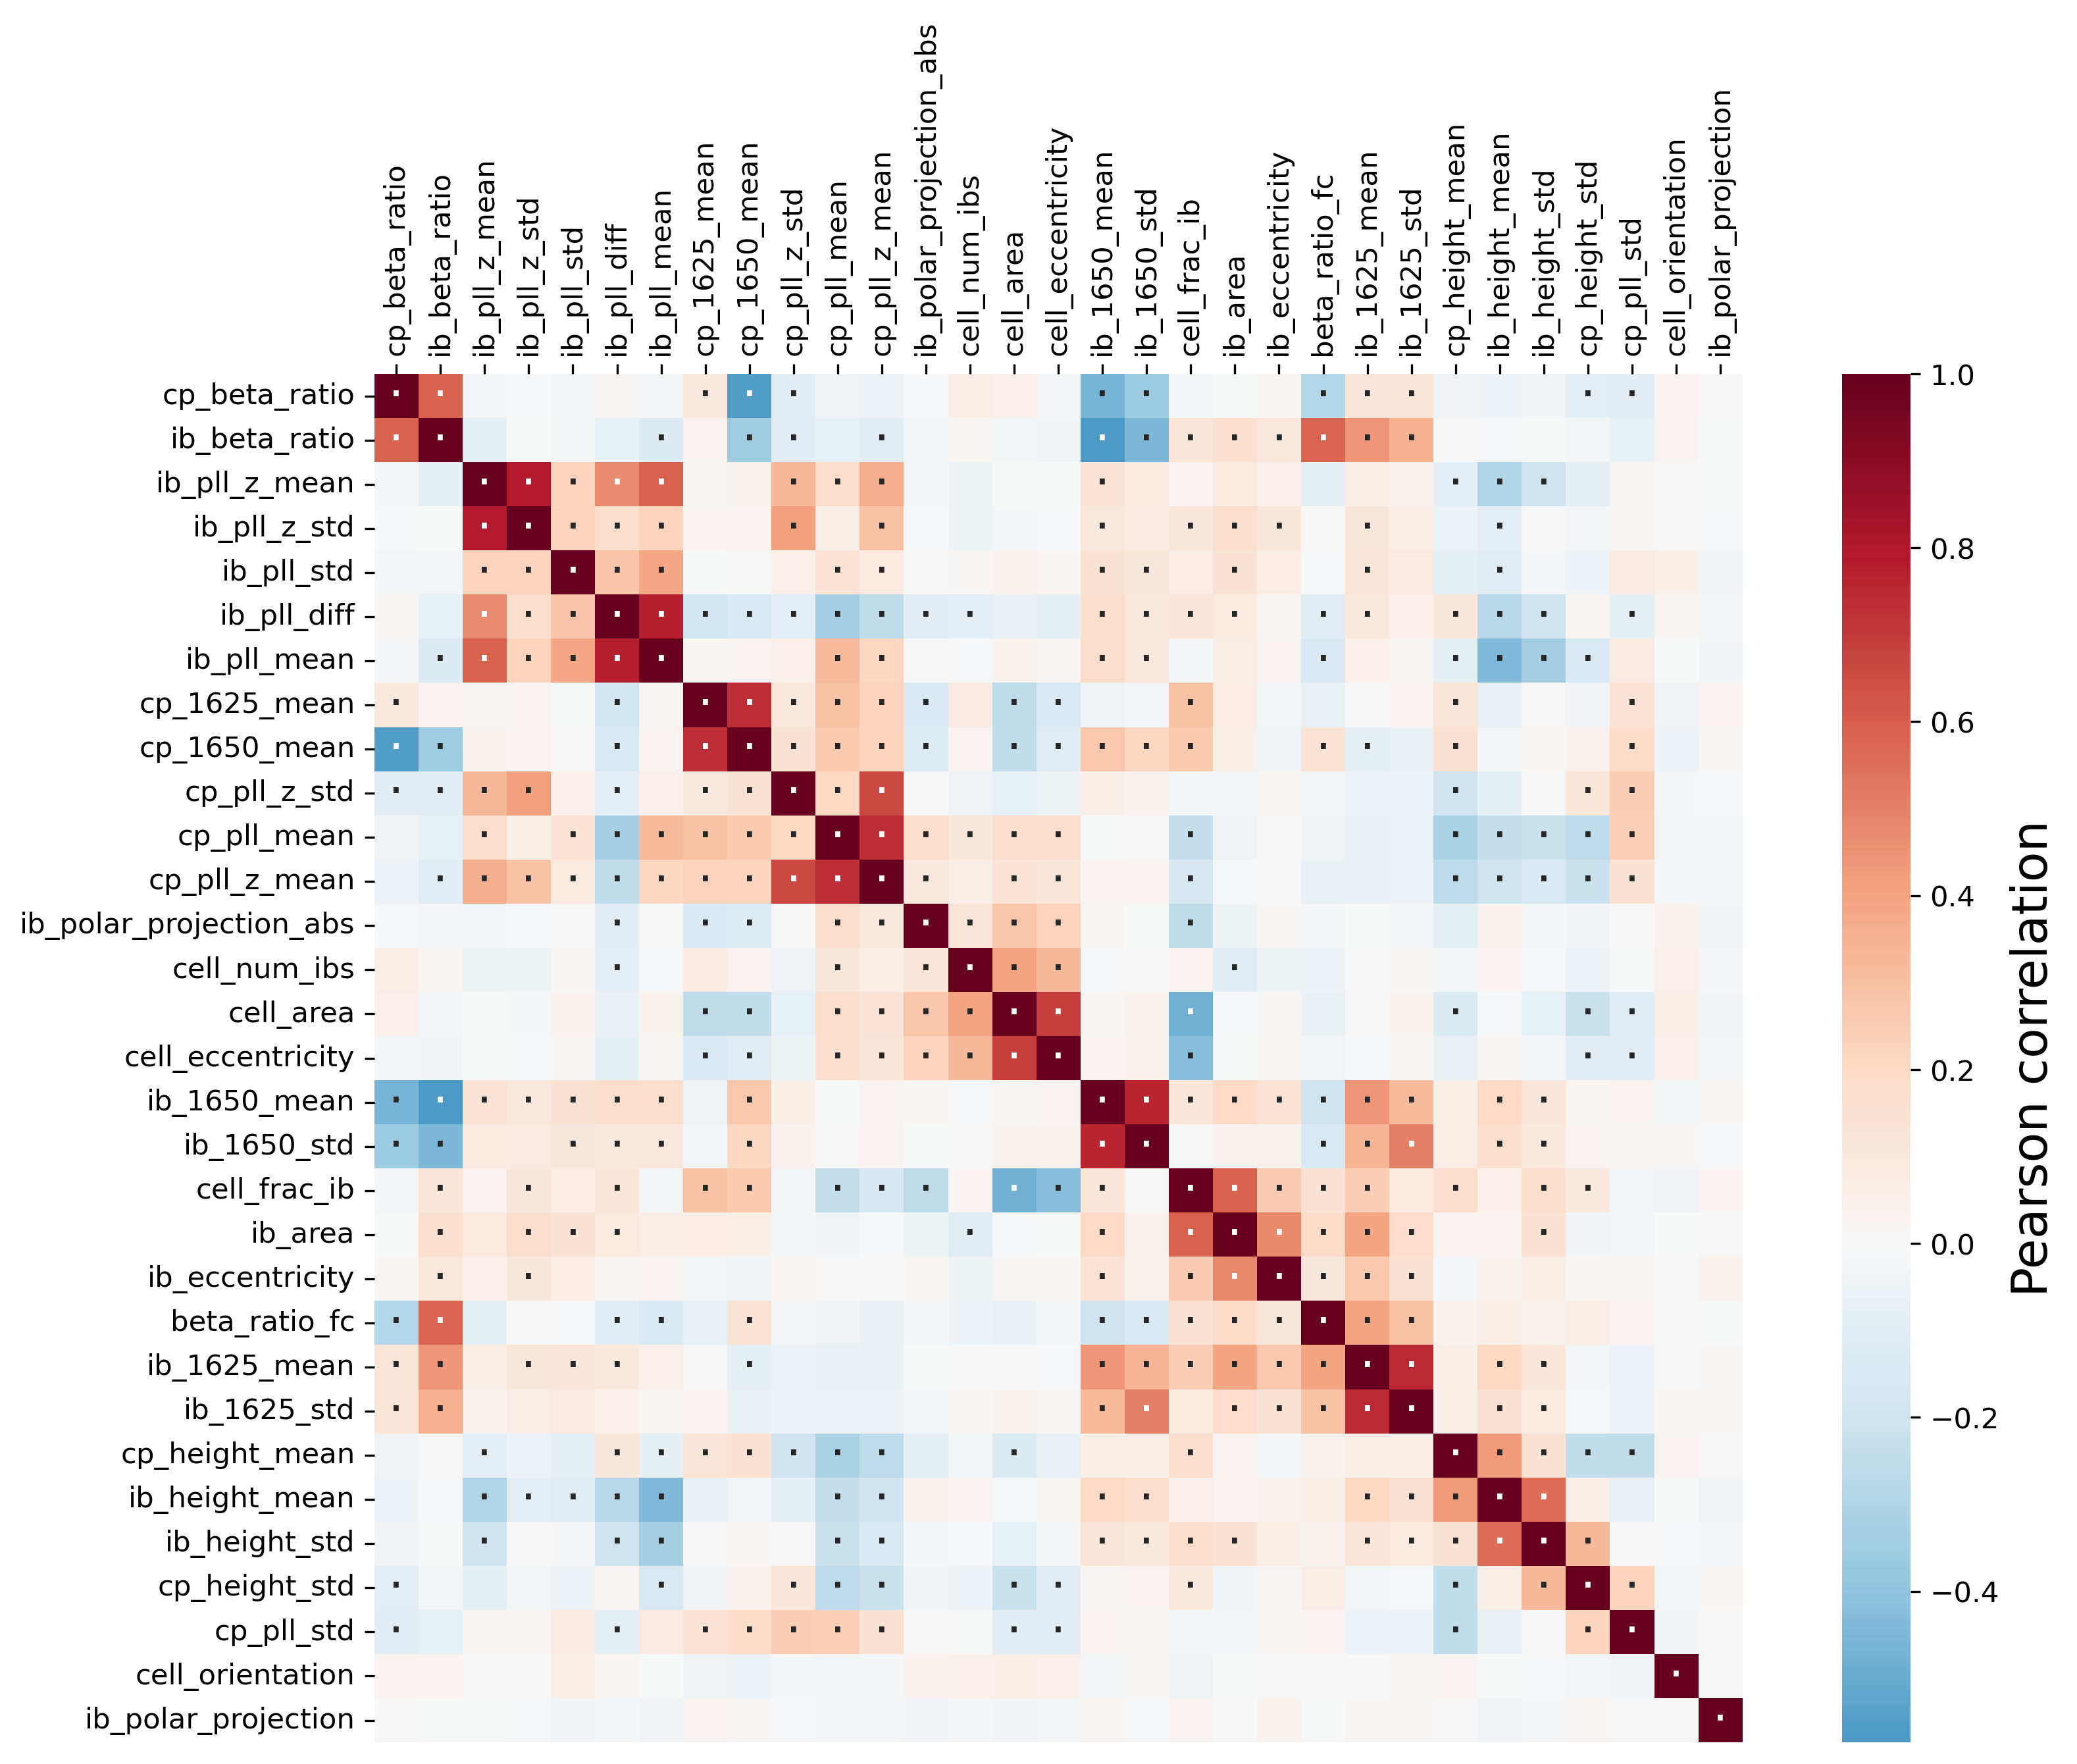

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import scipy.stats

def plot_correlations(ax=None):
    with plt.rc_context({
        'figure.figsize': (13, 9),
        'figure.dpi': 300,
        'font.size': 18,
        'savefig.bbox': 'tight',
        'xtick.labelsize': 'xx-small',
        'ytick.labelsize': 'xx-small'
    }):
        
        if ax is None: fig, ax = plt.subplots()

        # Drop the following columns
        drop_cols = [
            'cell_label', 'ib_area_px', 'cell_area_ib_px', 'centroid-0',
            'centroid-1', 'centroid-0_cell', 'centroid-1_cell', 'ib_num_cells', 
            'ib_centroid_y_frac', 'cell_axis_major_length', 'cell_axis_minor_length',
            'time_post_shock', 'time_post_shock_cell', 'ib_area_log', 'beta_ratio_diff',
            'series',
            'time_post_shock_cell',
            'cantilever_cell',
            'replicate_cell',
            'condition',
            'cantilever',
            'replicate',
            'condition_cell',
            'repeat',
            'spectra_loc',
            'repeat_cell',
            'spectra_loc_cell',
        ]

        # Normalise IB table
        dfsource = (
            ibtable
            .query('experiment == "recovery_timeline"')
            .set_index(['dataset_id', 'ib_label'])
            .drop(drop_cols, axis=1)
            .select_dtypes('number')
            .groupby('dataset_id', group_keys=False)
            .apply(lambda x: (x - x.mean(axis=0)) / x.std(axis=0))
            .dropna()#subset=['cp_1625_mean'])
        )

        # dfcorr = dfsource.corr(method='pearson')

        # Calculate correlations
        dfstats = (
            pd.DataFrame([
                {
                    'c1': c1, 
                    'c2': c2,
                    'x': scipy.stats.pearsonr(dfsource[c1], dfsource[c2])
                } 
                for c1 in dfsource.columns 
                for c2 in dfsource.columns
            ])
            .set_index(['c1', 'c2']).unstack()
            .x
        )

        # Reorder columns by hierarchical clustering
        r = dendrogram(linkage(dfstats.map(lambda x: x.statistic), method='average'), no_plot=True)
        reorder = dfstats.columns[r['leaves']]
        dfstats = dfstats.loc[reorder, reorder]

        # Define significance threshold
        n_tests = (len(dfstats)**2 - len(dfstats) / 2)
        alpha_threshold = 1- .05 / n_tests
        print(f'alpha_threshold = {alpha_threshold}')
        def is_significant(pearsonresult):
            ci = pearsonresult.confidence_interval(alpha_threshold)
            return '·' if (0 > ci.high) or (0 < ci.low) else ''
            
        sns.heatmap(
            dfstats.map(lambda x: x.statistic),
            cmap='RdBu_r', center=0, 
            square=True,
            cbar_kws=dict(label='Pearson correlation', location='right', fraction=.05),
            annot=dfstats.map(is_significant), fmt='', 
            ax=ax,
        )
        ax.set_aspect(1)
        ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set(xlabel='', ylabel='')

plot_correlations()

# Closeup

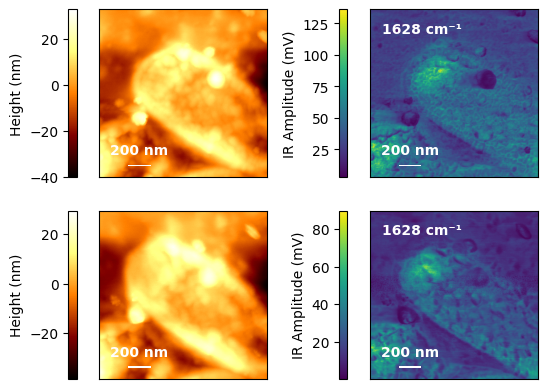

In [7]:
path = '../../../Experiments/2022-06 June/2022-06-15/2022-06-13 nexttip 1A hs1/'
doc_nt = aptwrapper.read(path + 'nexttip.axz')
doc_bruker = aptwrapper.read(path + 'tb005c.axz')

fig, ax = plt.subplots(2,2)
aptwrapper.plot_map(doc_nt.HeightMaps['Height 5'], ax[0,0])
aptwrapper.plot_map(doc_nt.HeightMaps['IR Amplitude 5'], ax[0,1])
aptwrapper.plot_map(doc_bruker.HeightMaps['Height 6'], ax[1,0])
aptwrapper.plot_map(doc_bruker.HeightMaps['IR Amplitude 6'], ax[1,1])

pixel width of closeup: 2.9296875 nm
resolution compared to other datasets: 13.333333333333334
imwidth 1.4970703125


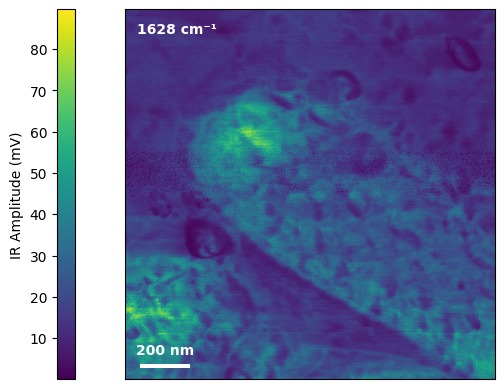

In [8]:
def plot_closeup(ax=None):
    if ax is None: fig, ax = plt.subplots()
    path = '../../../Experiments/2022-06 June/2022-06-15/2022-06-13 nexttip 1A hs1/'
    doc_nt = aptwrapper.read(path + 'nexttip.axz')
    doc_bruker = aptwrapper.read(path + 'tb005c.axz')
    irmap = doc_bruker.HeightMaps['IR Amplitude 6']
    aptwrapper.plot_map(irmap, ax)

    res=irmap.X.diff('x').mean().item()
    print('pixel width of closeup:',res*1e3,'nm' )
    print('resolution compared to other datasets:', 20/512/res)
    print('imwidth', irmap.X.max().item() - irmap.X.min().item())

plot_closeup()

# Composite

pixel width of closeup: 2.9296875 nm
resolution compared to other datasets: 13.333333333333334
imwidth 1.4970703125
alpha_threshold = 0.9999471179270227


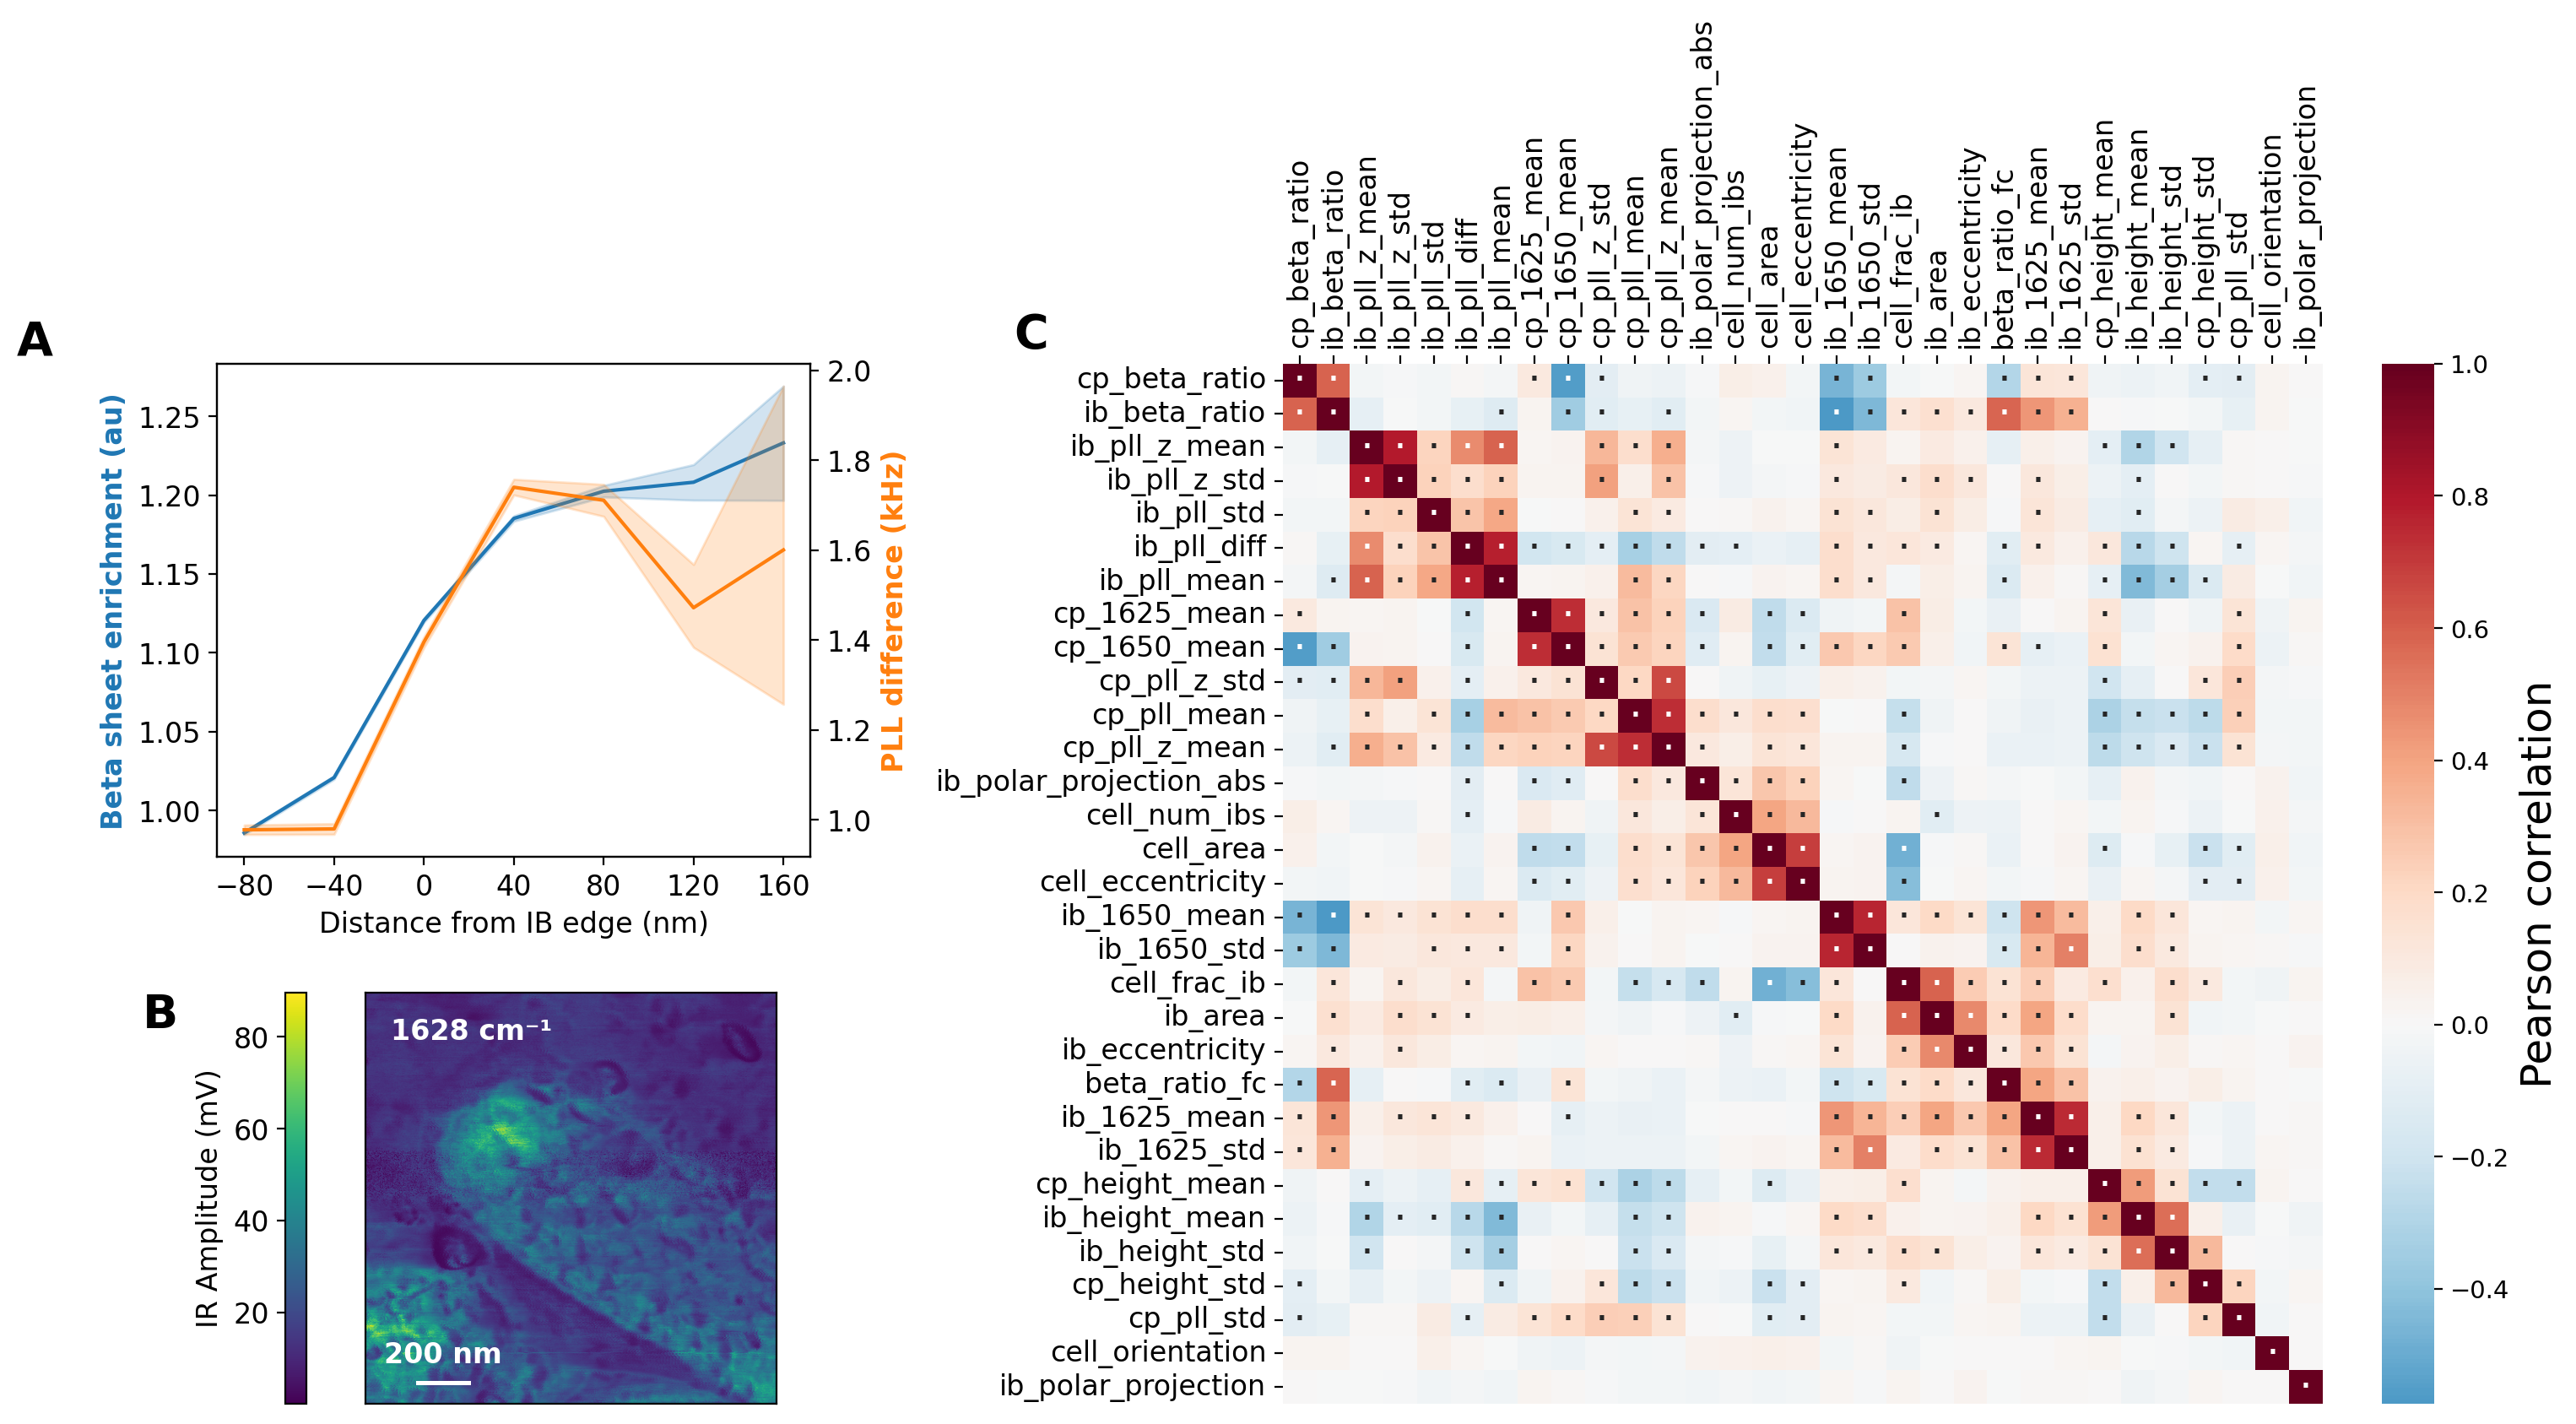

In [9]:
from matplotlib.gridspec import GridSpecFromSubplotSpec

with plt.rc_context({
    'figure.figsize': (17,8),
    'figure.dpi': 200,
    'font.size': 12,
    'savefig.bbox': 'tight',
    'legend.loc': 'upper right',
}):
    
    fig, ax = plt.subplot_mosaic(
        mosaic=[
            ['a', 'c'],
            ['b', 'c']
        ],
        gridspec_kw={
            'height_ratios': [1.2, 1],
            'width_ratios': [1, 2],
            'hspace': .3,
            'wspace': .5
        },
    )

    # ax['b'].axis('off')
    # gs = GridSpecFromSubplotSpec(
    #     1, 2, ax['b'], wspace=0, width_ratios=[1, .1]
    # )
    # axb = fig.add_subplot(gs[0])

    plot_ib_anatomy(ax['a'])
    plot_closeup(ax['b'])
    plot_correlations(ax['c'])

    kwargs = dict(
        ha='right',
        va='top',
        xycoords=('axes points',
        'axes fraction'),
        fontsize=20,
        fontweight='bold')
    
    ax['a'].annotate('A', (-70,1.09), **kwargs)
    ax['b'].annotate('B', (-80, 1), **kwargs)
    ax['c'].annotate('C', (-100,1.05), **kwargs)

    import os
    output_directory = "../figures"
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    plt.savefig('../figures/figure_6.pdf', bbox_inches='tight')